### Implimentaion of ant colony algorithm. Data used was from Kaggles 2018 Traveling Santa Problem. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import seaborn as sns
from copy import copy

In [2]:
import scipy

In [64]:
cities = pd.read_csv('cities.csv')

In [65]:
def is_prime(n):
    if n % 2 == 0 and n > 2: 
        return False
    return all(n % i for i in range(3, int(math.sqrt(n)) + 1, 2))

In [66]:
cities['prime'] = cities['CityId'].apply(is_prime)
cities['prime'] = cities['prime'].astype(int)

In [67]:
cities.head(10)

,CityId,X,Y,prime
0,0,316.836739,2202.340707,1
1,1,4377.405972,336.602082,1
2,2,3454.158198,2820.053011,1
3,3,4688.099298,2935.898056,1
4,4,1010.696952,3236.750989,0
5,5,2474.230877,1435.514651,1
6,6,1029.277795,2721.800952,0
7,7,3408.887685,199.585793,1
8,8,1304.006125,2657.427246,0
9,9,4211.525725,2294.595208,0


Reducing data size; algorithm will only solve the first 1000 cities. The full dataset contains 200k cities. 

In [68]:
cities_loc_array = np.array(cities.iloc[:1000,1:3])

In [69]:
cities_loc_dict = cities.iloc[:1000,1:4].T.to_dict('list')

In [70]:
cities_list = list(cities.iloc[:1000,0:1].values)

In [71]:
len(cities_loc_dict)

1000

Defining the pheremone graph.

In [91]:
class Graph(object):
    def __init__(self,city_list,rate):
        self.rate = rate
        #self.m_cities = copy(city_list)
        #self.city_index = dict(zip(city_list,range(len(city_list))))
        self.ph_matrix = np.ones((len(city_list),len(city_list)))#, dtype= 'float16' )
        
        
    def update_trail(self,city_1,city_2,weight):
        # below i assume my dictionary only has pharamone weights, 
        self.ph_matrix[self.city_index[city_1],self.city_index[city_2]] += weight
    
    def update_trail2(self,xs,ys,weight):
        # below i assume my dictionary only has pharamone weights, 
        self.ph_matrix[xs,ys] += weight


    def evapourate(self):
        self.ph_matrix = np.multiply(self.ph_matrix,(1-self.rate))
    

Defining the Ants.

In [92]:
class Ant(object):
    def __init__(self, city_list, city_loc_dict, city_loc_array):
        '''
        city_list, city_loc_dict, city_loc_array
        '''
        self.trip_order = []
        self.total_trip_length = 0
        self.city_list = copy(city_list)
        self.city_loc_dict = city_loc_dict
        self.city_loc_array = city_loc_array
        start_city = 0
        self.trip_order.append(start_city)
        self.city_list.remove(start_city)
        # will need to initialize city_list with a start city
    
    
    def update_trip_order(self, city, x):
        c2 = self.trip_order[-1]
        self.trip_order.append(city)
        xc1 = self.city_loc_dict[c2][0]
        xc2 = self.city_loc_dict[city][0]
        yc1 = self.city_loc_dict[c2][1]
        yc2 = self.city_loc_dict[city][1]
        distance = math.sqrt((xc1-xc2)**2+(yc1-yc2)**2)
        if (x+1) % 10 == 0 and self.city_loc_dict[city][2] == 0:
            self.total_trip_length += (distance * 1.15)
        else:
            self.total_trip_length += distance
        self.city_list.remove(city)
    
    
    def update_city_list(self, city):
        self.city_list.remove(city)
        
    def distlist_cc(self, ccxy,ncxy):
        b = scipy.spatial.distance.cdist(ccxy,ncxy)[0]
        #b = [((ccx-ncx[x])**2+(ccy-ncy[x])**2)**(1/2) for x in range(len(ncx))]
        return b
   
    def find_next_city(self, graph):
        
        # in this portion i need to calculate distances dynamically. 
        
        self.current_city = self.trip_order[len(self.trip_order)-1] # returns last city from trip list
        #self_current_city is same as below. 
        #self.current_city_index = city_graph.city_index[self.current_city] indexing has been and gone

        #might change this after parralelling so that all objects get their own copy of city list
        ccx = self.city_loc_dict[self.current_city][0]
        ccy = self.city_loc_dict[self.current_city][1]
        ccxy = np.array([ccx,ccy]).reshape(1,2)
        
        #self.remaining_cities = city_graph.m_cities.iloc[self.city_list] # if i just grab first column this si same as remaining city index
        
        # 0 is x
        # 1 is y
        #ncx = self.city_loc_array[tuple(self.city_list),0]
        #ncy = self.city_loc_array[tuple(self.city_list),1]
        ncxy = self.city_loc_array[tuple(self.city_list),(0,1)]
        
        #self.dist_matrix = [math.sqrt((ccx-ncx[x])**2+(ccy-ncy[x])**2) for x in range(len(ncx))]
        #self.dist_matrix = self.distlist_cc(ccx,ccy,ncx,ncy)
        self.dist_matrix = self.distlist_cc(ccxy,ncxy)
        
        self.dist_matrix = np.array(self.dist_matrix).reshape(-1,1)
        
        # line below might be able to be kept
        self.remain_city_from_current = graph.ph_matrix[self.current_city,self.city_list]
        
        # this distance matric needs to be rewritten

        self.combination = self.remain_city_from_current * 1/self.dist_matrix
        self.combination_probs = (self.combination+1)/np.sum(self.combination+1)
        self.combination_probs = self.combination_probs.reshape(-1,)

        reshaped_city_list = np.array(self.city_list).reshape(-1,)

        
        self.next_city = np.random.choice(reshaped_city_list, p = self.combination_probs)
        
        return self.next_city



Defining the model.

In [93]:
%%time
class ACO(object):
    def __init__(self,city_list, graph, city_loc_dict, city_loc_array, generations = 30, ants=5):
        # turn this into a function. 
        self.city_list = city_list
        self.graph = graph
        self.city_loc_dict = city_loc_dict
        self.city_loc_array = city_loc_array
        self.number_of_ants = ants
        self.generations = generations
        self.shortest_trip = []
        self.path_of_short_trip = []
        self.ph_max = []
        self.ph_min = []
        self.phf_max = []
        self.phf_min = []
        self.ph_maxs = []
        self.ph_mins = []
        self.phf_maxs = []
        self.phf_mins = []


    def weight_all_trips(self,array_of_lengths, short):
        '''
        Modifiy pheremone weights here. 
        '''

        return array_of_lengths

    def ant_move(self,ant,v):
        n_city = ant.find_next_city(self.graph)
        ant.update_trip_order(n_city,v)
        #ant.update_city_list(n_city)
    
    def ant_move_p(self,arg):
        v, ant = arg
        n_city = ant.find_next_city(self.graph)
        ant.update_trip_order(n_city,v)
        #ant.update_city_list(n_city)


    def solve(self):
        for i in range(self.generations):
            self.ant_colony = [Ant(self.city_list, self.city_loc_dict, self.city_loc_array) for x in range(self.number_of_ants)]
            for v in range(len(self.city_list)-1):
                for ant in self.ant_colony:
                    self.ant_move(ant,v)
                
                    
                if v % 10 == 0:    
                    self.graph.evapourate()
                #self.phf_max.append(city_graph.ph_matrix.max())
                #self.phf_min.append(city_graph.ph_matrix.min())
                #self.phf_maxs.append(self.graph.ph_matrix.max())
                #self.phf_mins.append(self.graph.ph_matrix.min())

            list_of_lengths = [ant.total_trip_length for ant in self.ant_colony]
            list_of_lengths = np.array(list_of_lengths)
            short_i = np.argmin(list_of_lengths)
            self.path_of_short_trip.append(self.ant_colony[short_i].trip_order)

            short = list_of_lengths.min() 
            self.shortest_trip.append(short)
            weights = self.weight_all_trips(list_of_lengths, short)

            for i, ant in enumerate(self.ant_colony):
                x = tuple(ant.trip_order[:-1])
                y = tuple(ant.trip_order[1:])
                w = weights[i]
                self.graph.update_trail2(x,y,w)


            self.ph_max.append(city_graph.ph_matrix.max())
            self.ph_min.append(city_graph.ph_matrix.min())
            self.ph_maxs.append(self.graph.ph_matrix.max())
            self.ph_mins.append(self.graph.ph_matrix.min())




CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 77.2 µs


Generate a graph and model object.

In [94]:
%%time
city_graph = Graph(cities_list,.005)
model = ACO(cities_list,city_graph, cities_loc_dict, cities_loc_array)


CPU times: user 5.36 ms, sys: 0 ns, total: 5.36 ms
Wall time: 3.75 ms


Solve model.

In [95]:
%%time
model.solve()

CPU times: user 10min 23s, sys: 0 ns, total: 10min 23s
Wall time: 2min 35s


Shortest trip progression.

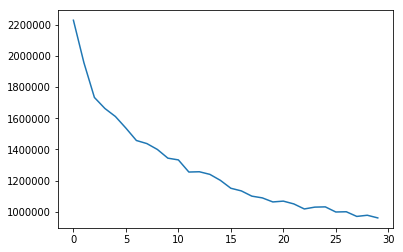

In [96]:
plt.plot(model.shortest_trip)

In [109]:
len(model.path_of_short_trip[-5:-1])

4

In [114]:
import tqdm

Generating a meta model. As the model progresses the rate of improvement decreases. In an attempt to further drive up model scores I rerun the model multiple times. Each additional time the model is run the pheromone graph is pre-initiated with pheromones from the best 4 trips of the previous run.

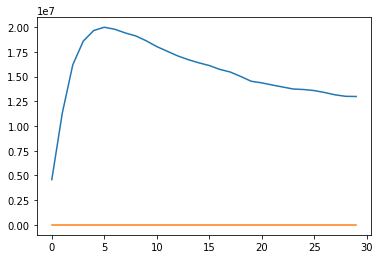

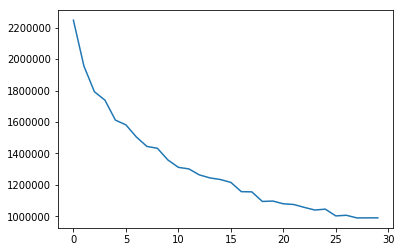

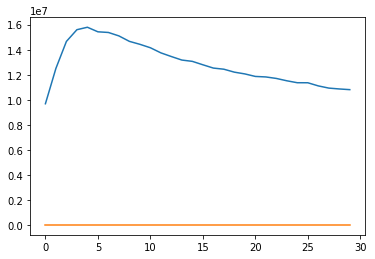

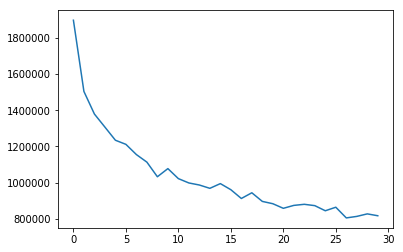

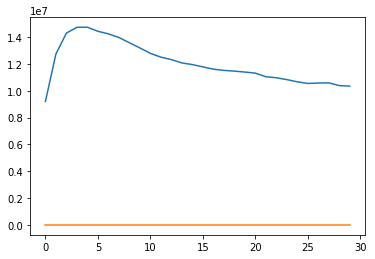

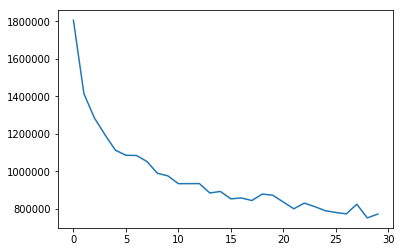

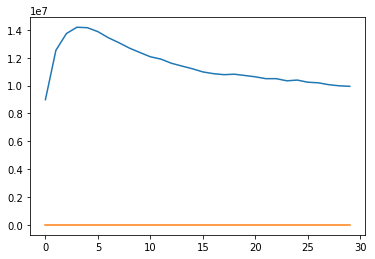

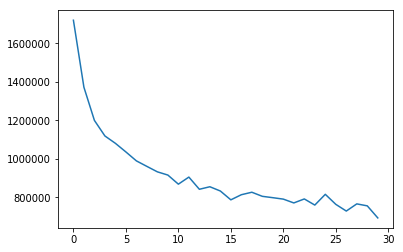

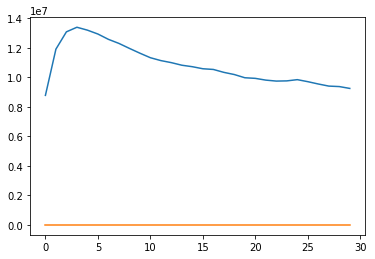

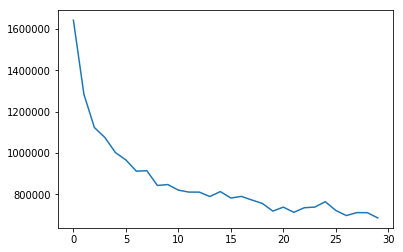

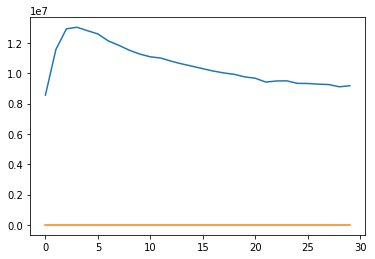

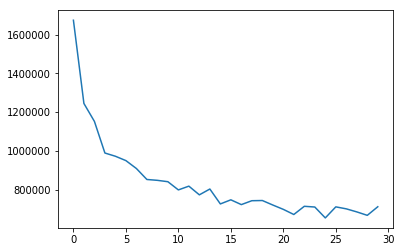

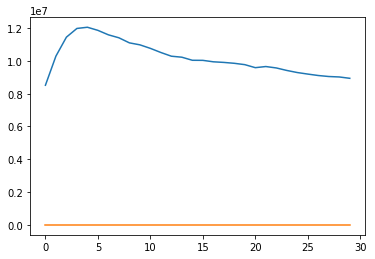

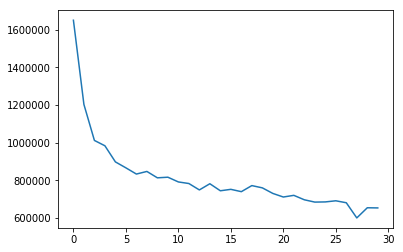

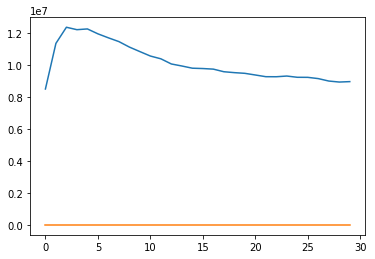

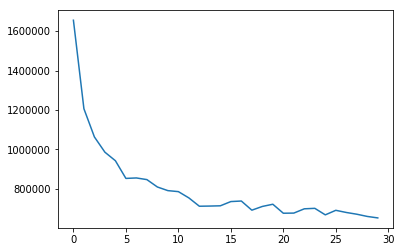

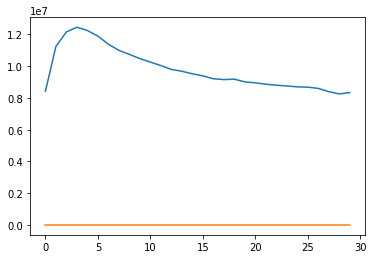

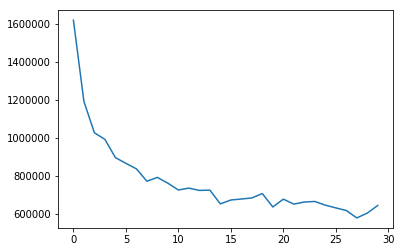

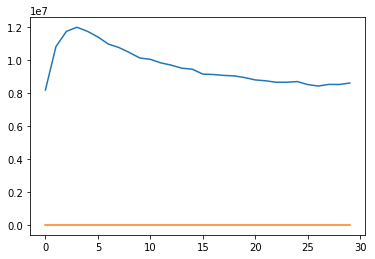

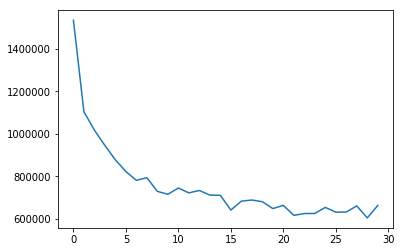

In [119]:
meta_generation = range(10)
meta_gen_short = []
all_trips = []
for mg in meta_generation:
    if mg == 0:
        city_graph = Graph(cities_list,.005)
        model = ACO(cities_list,city_graph, cities_loc_dict, cities_loc_array)
        model.solve()
        plt.plot(model.ph_max)
        plt.plot(model.ph_min)
        plt.show()
        plt.plot(model.shortest_trip)
        plt.show()
        all_trips.append(model.shortest_trip)
        meta_gen_short.append(np.array(model.shortest_trip).min())
        initializers = model.path_of_short_trip[-5:-1]
    else:
        city_graph = Graph(cities_list,.005)
        for i in initializers:
            x = tuple(i[:-1])
            y = tuple(i[1:])
            w = 40000
            city_graph.update_trail2(x,y,w)
        model = ACO(cities_list,city_graph, cities_loc_dict, cities_loc_array)
        model.solve()
        plt.plot(model.ph_max)
        plt.plot(model.ph_min)
        plt.show()
        plt.plot(model.shortest_trip)
        plt.show()
        all_trips.append(model.shortest_trip)
        meta_gen_short.append(np.array(model.shortest_trip).min())
        initializers = model.path_of_short_trip[-5:-1]
        

A graph showing the results of the the various runs of the meta-model. 

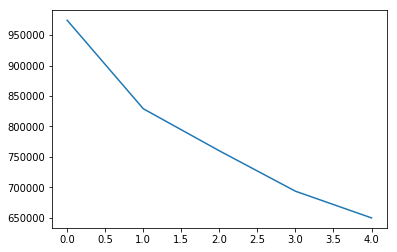

In [118]:
plt.plot(meta_gen_short)